In [22]:
import numpy as np
import pandas as pd
df=pd.read_csv('cleaned_tweets_with_label.csv', encoding='utf8')

In [23]:
from textblob import TextBlob
# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
# TextBlob sentiment analysis
df['textblob'] = df['text'].apply(lambda x:
                                  TextBlob(str(x)).sentiment.polarity)

# TextBlob sentiment analysis
df['textblob_analysis'] = df['textblob'].apply(analysis)


In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
# VADER sentiment analysis
df['vader'] = df['text'].apply(lambda x:
                               vader.polarity_scores(str(x))['compound'])
# function to calculate vader sentiment
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

df['vader_analysis'] = df['vader'].apply(vader_analysis)

In [25]:
import nltk
import ssl
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()

In [26]:
pos=neg=obj=count=0

postagging = []

for review in df['text']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

df['pos_tags'] = postagging

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
senti_score = []

for pos_val in df['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0 
df['senti_score'] = senti_score

In [27]:
def sentiwordnet_analysis(sentiment):

    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"
df['senti_analysis'] = df['senti_score'].apply(sentiwordnet_analysis)

In [28]:
#count the number of textblob
tb_counts = df.textblob_analysis.value_counts()
tb_counts

Positive    4384
Neutral     3588
Negative    2028
Name: textblob_analysis, dtype: int64

In [29]:
#count the number of vader
vader_counts = df.vader_analysis.value_counts()
vader_counts

Neutral     6181
Positive    2734
Negative    1085
Name: vader_analysis, dtype: int64

In [30]:
#count the number of sentiwordnet
senti_counts = df.senti_analysis.value_counts()
senti_counts

Positive    3748
Neutral     3371
Negative    2881
Name: senti_analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7f8854d38820>,
 [Text(0.42159024296671327, 1.0160027888914813, 'Positive'),
  Text(-1.0594478473771793, -0.29592272418295457, 'Neutral'),
  Text(0.8337769457941705, -1.0617513855240055, 'Negative')],
 [Text(0.22995831434547995, 0.5541833393953534, '37.5%'),
  Text(-0.5778806440239159, -0.1614123950088843, '33.7%'),
  Text(0.5249706695741073, -0.6685101316262256, '28.8%')])

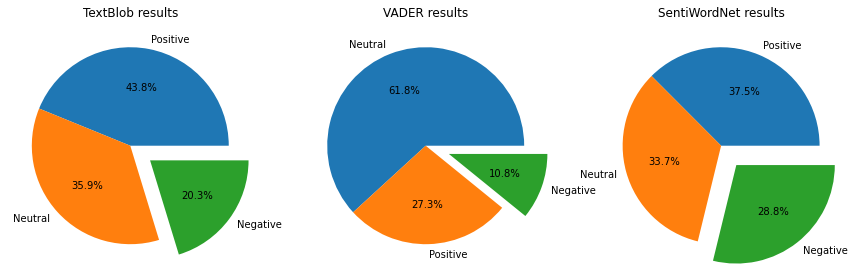

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob results")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results")
plt.pie(senti_counts.values, labels = senti_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [32]:
df['result'] = df.apply(lambda x: x.textblob_analysis == x.vader_analysis == x.senti_analysis, axis = 1)

In [33]:
df.head()

,Unnamed: 0,Unnamed: 0.1,rating,id,date,flag,user,text,tidy_tweet,textblob,textblob_analysis,vader,vader_analysis,pos_tags,senti_score,senti_analysis,result
0,0,894059,1,1692137234,Sun May 03 19:21:16 PDT 2009,NO_QUERY,cariquinn,@NZSoulGirl Hey there! Yum...sangria! And snor...,hey snorkel sound amaze glad fun,0.491667,Positive,0.8996,Positive,"[(@, JJ), (NZSoulGirl, NNP), (Hey, NNP), (ther...",0.375,Positive,True
1,1,1467016,1,2064555259,Sun Jun 07 06:35:08 PDT 2009,NO_QUERY,Nigel_Derbyfan,Enjoyed that. Now for Sunday dinner,enjoy sunday dinner,0.500000,Positive,0.5106,Positive,"[(Enjoyed, VBN), (that, IN), (., .), (Now, RB)...",0.000,Neutral,False
2,2,1150195,1,1978427680,Sat May 30 23:19:31 PDT 2009,NO_QUERY,YoungmoneyReef,"show was awesome vegas, u made the last night ...",show awesome vega make last night tour memorable,0.500000,Positive,0.6249,Positive,"[(show, NN), (was, VBD), (awesome, JJ), (vegas...",0.625,Positive,True
3,3,1274449,1,2000971003,Mon Jun 01 23:28:13 PDT 2009,NO_QUERY,DoreenCotinola,@DKA34 Damon welcome to twitter Nation!,damon welcome twitter nation,1.000000,Positive,0.5093,Positive,"[(@, JJ), (DKA34, NNP), (Damon, NNP), (welcome...",0.250,Positive,True
4,4,620938,0,2228589656,Thu Jun 18 14:37:57 PDT 2009,NO_QUERY,tmac_82,@teemwilliams &amp; @dc3plusme: I thought I fo...,think find mine leave guy think well,0.250000,Positive,0.5927,Positive,"[(@, NNP), (teemwilliams, NNP), (&, CC), (amp,...",0.875,Positive,True


In [34]:
false_text_count = df.result.value_counts()
false_text_count

False    6123
True     3877
Name: result, dtype: int64

In [35]:
df.to_csv("tweets_polarity.csv")